# Bias correct CESM2 wind speeds to ERA5 using stress

In [ ]:
import xarray as xr
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import glob
import sys
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range
# from nemo_python_git.interpolation import interp_latlon_cf, regrid_era5_to_cesm2, extend_into_mask
from nemo_python_git.constants import cesm2_ensemble_members
from nemo_python_git.file_io import find_cesm2_file, find_processed_cesm2_file

# %load_ext line_profiler

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
CESM2_u  = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_3-hourly_UBOT_y1979.nc').sortby(['lat','lon']).sel(lat=slice(-90,-50))
CESM2_v  = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_3-hourly_VBOT_y1979.nc').sortby(['lat','lon']).sel(lat=slice(-90,-50))
ERA5_u   = xr.open_dataset(f'{base_dir}ERA5-forcing/hourly/processed/u10_y1979.nc').sortby(['lat','lon']).sel(lat=slice(-90,-50)).isel(lon=slice(0,None,5)).resample(time='3h').mean()
ERA5_v   = xr.open_dataset(f'{base_dir}ERA5-forcing/hourly/processed/v10_y1979.nc').sortby(['lat','lon']).sel(lat=slice(-90,-50)).isel(lon=slice(0,None,5)).resample(time='3h').mean()

In [3]:
CESM2_landmask = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/raw/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h0.LANDFRAC.197001-197912.nc').sortby('lat').sel(lat=slice(-90,-50)).isel(time=0)
CESM2_landmask['lon'] = fix_lon_range(CESM2_landmask['lon'])
CESM2_landmask = CESM2_landmask.sortby('lon')

ERA5_landmask = xr.open_dataset(f'{base_dir}ERA5-forcing/climatology/land_sea_mask.nc').isel(time=0).rename({'longitude':'lon','latitude':'lat'})
ERA5_landmask['lon'] = fix_lon_range(ERA5_landmask['lon'])
ERA5_landmask = ERA5_landmask.sortby(['lat','lon']).sel(lat=slice(-90,-50)).isel(lon=slice(0,None,5))

In [4]:
CESM2_angle = np.arctan2(CESM2_v.VBOT, CESM2_u.UBOT)
ERA5_angle  = np.arctan2(ERA5_v.v10, ERA5_u.u10)

In [5]:
CESM2_wind_speed = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/ensemble_mean/CESM2-LE2_wind_speed_3-hourly_ensemble_1979-2024_mean_monthly.nc')
ERA5_wind_speed  = xr.open_dataset(f'{base_dir}ERA5-forcing/climatology/ERA5_wind_speed_3-hourly_1979-2024_mean_monthly.nc')

In [42]:
CESM2_monthly_angle = CESM2_angle.groupby('time.month').mean(dim='time').where(CESM2_landmask.LANDFRAC==0)
ERA5_monthly_angle  = ERA5_angle.groupby('time.month').mean(dim='time').where(ERA5_landmask.lsm==0)
CESM2_monthly_speed = CESM2_wind_speed.where(CESM2_landmask.LANDFRAC==0)
ERA5_monthly_speed  = ERA5_wind_speed.where(ERA5_landmask.lsm==0)

In [54]:
for pair in [(0, -1), (1, 0), (0, 1), (-1, 0)]:
    print(f'u: {pair[1]}, v: {pair[0]}, angle: {np.rad2deg(np.arctan2(pair[0], pair[1]))}')

u: -1, v: 0, angle: 180.0
u: 0, v: 1, angle: 90.0
u: 1, v: 0, angle: 0.0
u: 0, v: -1, angle: -90.0


In [43]:
CESM2_mean_u = np.cos(CESM2_monthly_angle) * CESM2_wind_speed
CESM2_mean_v = np.sin(CESM2_monthly_angle) * CESM2_wind_speed
ERA5_mean_u  = np.cos(ERA5_monthly_angle) * ERA5_wind_speed
ERA5_mean_v  = np.sin(ERA5_monthly_angle) * ERA5_wind_speed

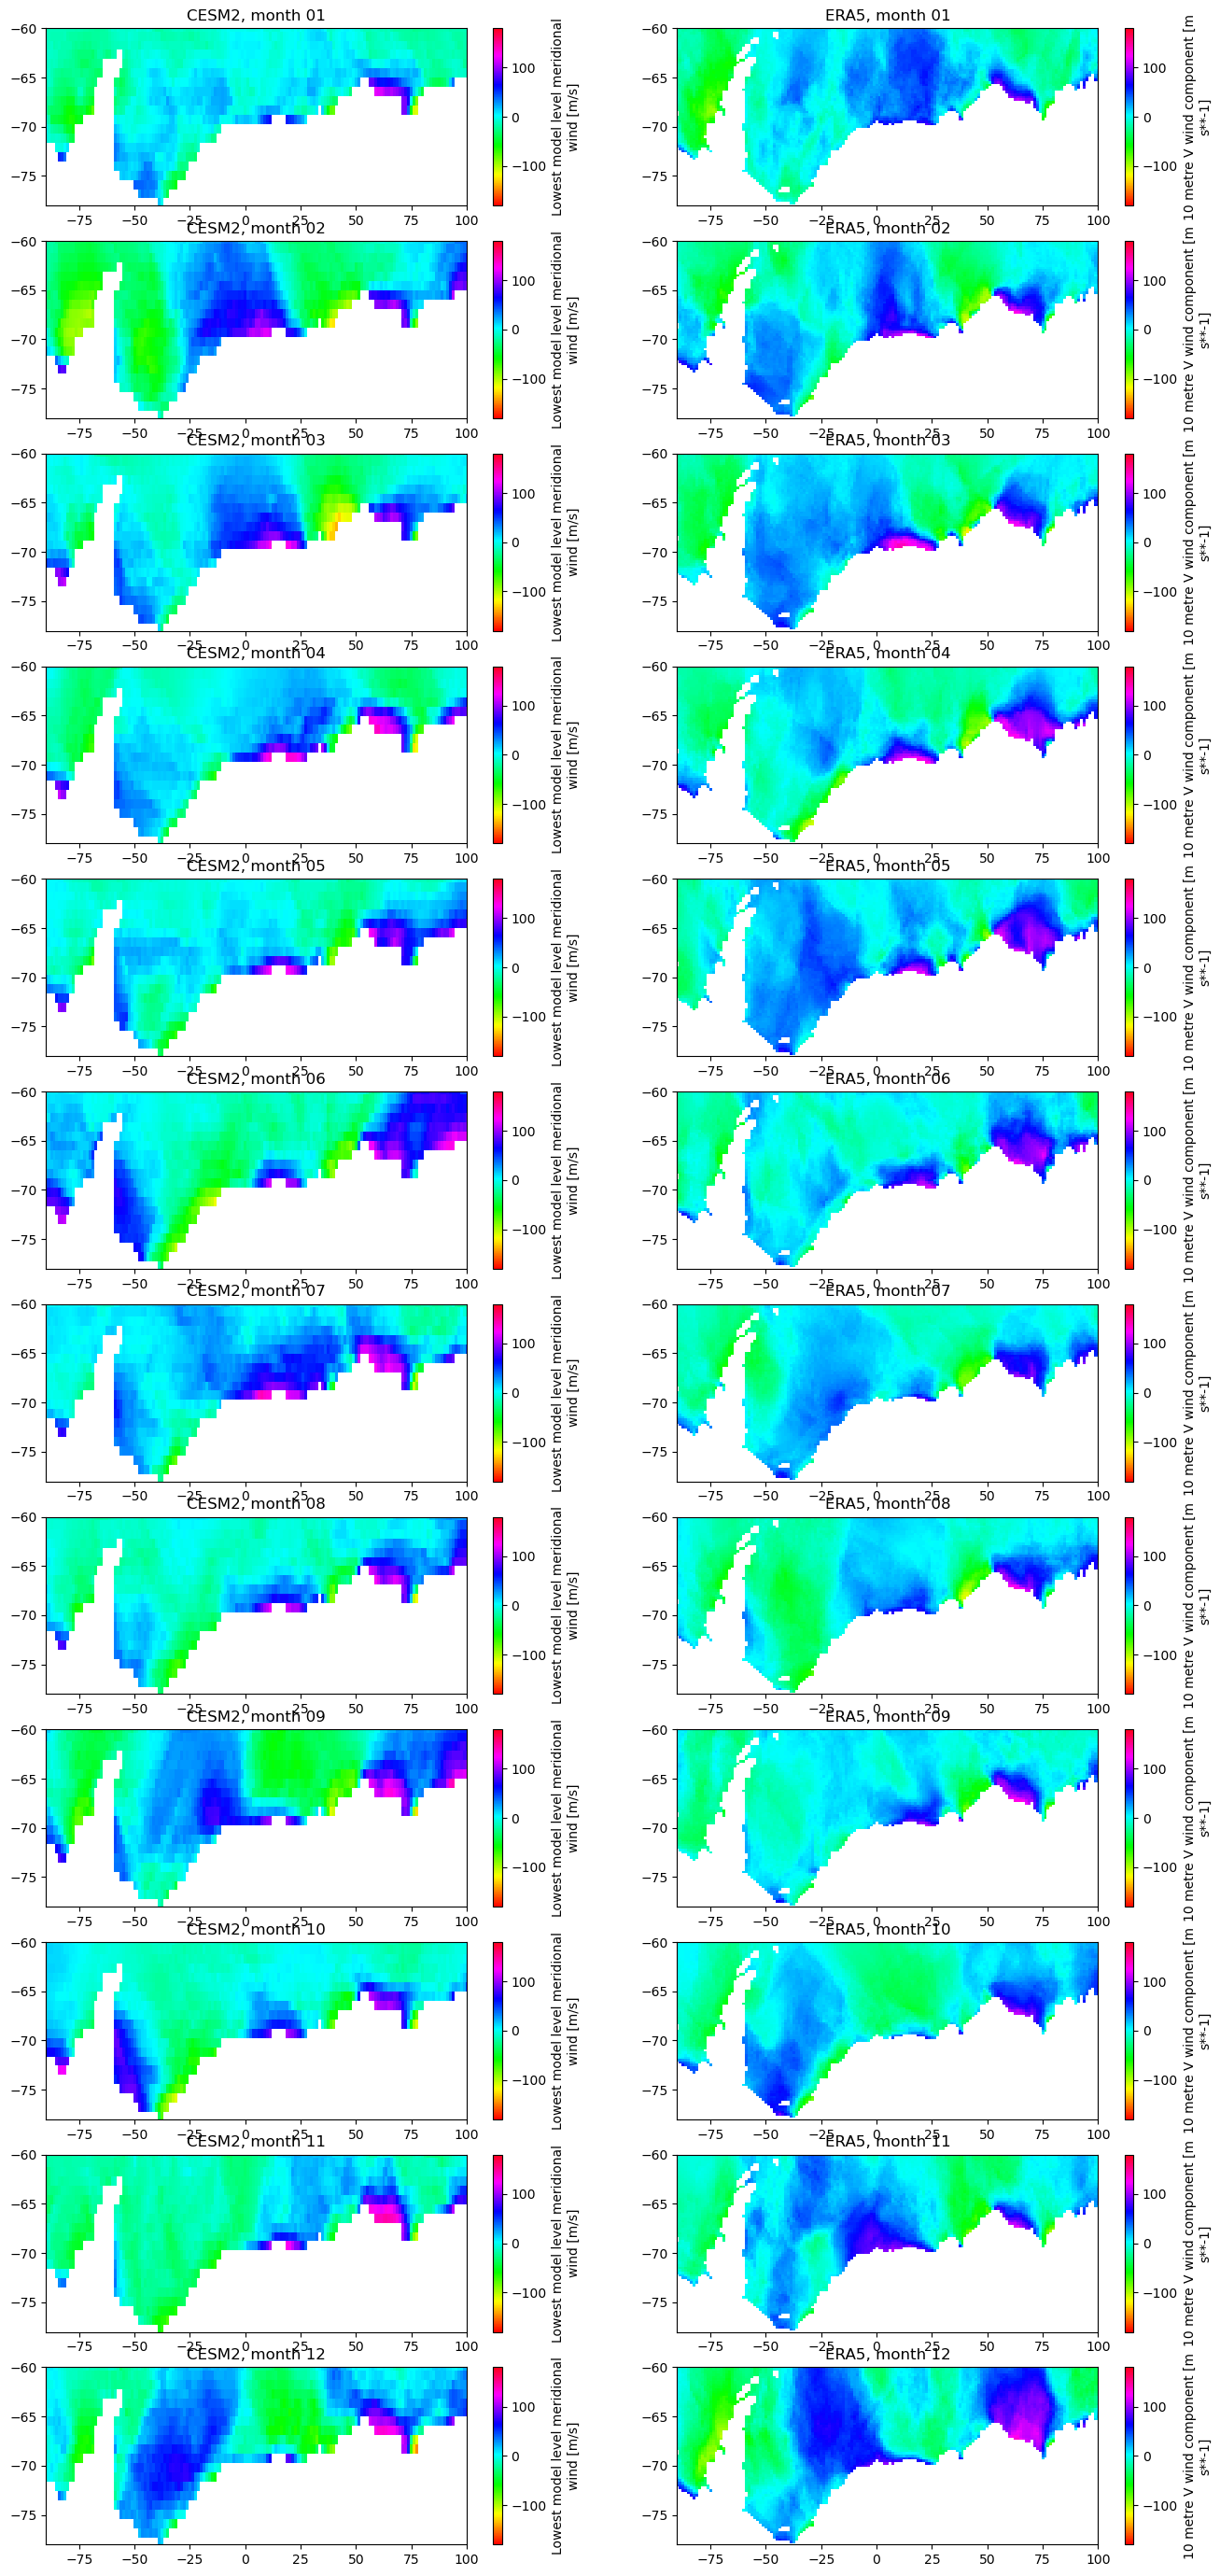

In [12]:
fig, ax = plt.subplots(12,2,figsize=(16,35))
subset  = {'lon':slice(0,None,6), 'lat':slice(0,None,1)}
subset2 = {'lon':slice(0,None,6), 'lat':slice(0,None,3)}

for m, month in enumerate(range(0,12)):
    np.rad2deg(CESM2_monthly_angle.isel(month=month)).plot(ax=ax[m,0], cmap='hsv', vmin=-180, vmax=180)
    np.rad2deg(ERA5_monthly_angle.isel(month=month)).plot(ax=ax[m,1], cmap='hsv', vmin=-180, vmax=180)
    
    # ql = ax[m,0].quiver(CESM2_monthly_angle.isel(**subset).lon, CESM2_monthly_angle.isel(**subset).lat,
    #                     CESM2_mean_u.isel(month=month).isel(**subset).values, CESM2_mean_v.isel(month=month).isel(**subset).values,
    #                     width=2.5e-3, scale=300, color='k')
    
    # ql = ax[m,1].quiver(ERA5_monthly_angle.isel(**subset2).lon, ERA5_monthly_angle.isel(**subset2).lat,
    #                     ERA5_mean_u.isel(month=month).isel(**subset2).values, ERA5_mean_v.isel(month=month).isel(**subset2).values,
    #                     width=2.5e-3, scale=300, color='k')
    ax[m,0].set_title(f'CESM2, month {m+1:02}')
    ax[m,1].set_title(f'ERA5, month {m+1:02}')
    
for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');
    axis.set_xlim(-90, 100)
    axis.set_ylim(-78, -60)

In [ ]:
subset2 = {'lon':slice(0,None,2), 'lat':slice(0,None,2)}
np.rad2deg(CESM2_monthly_angle.mean(dim='month')).interp(lon=ERA5_monthly_angle.isel(**subset2).lon, \
                                                         lat=ERA5_monthly_angle.isel(**subset2).lat)
# np.rad2deg(ERA5_monthly_angle.mean(dim='month')).plot(ax=ax[1], cmap='hsv', vmin=-180, vmax=180)

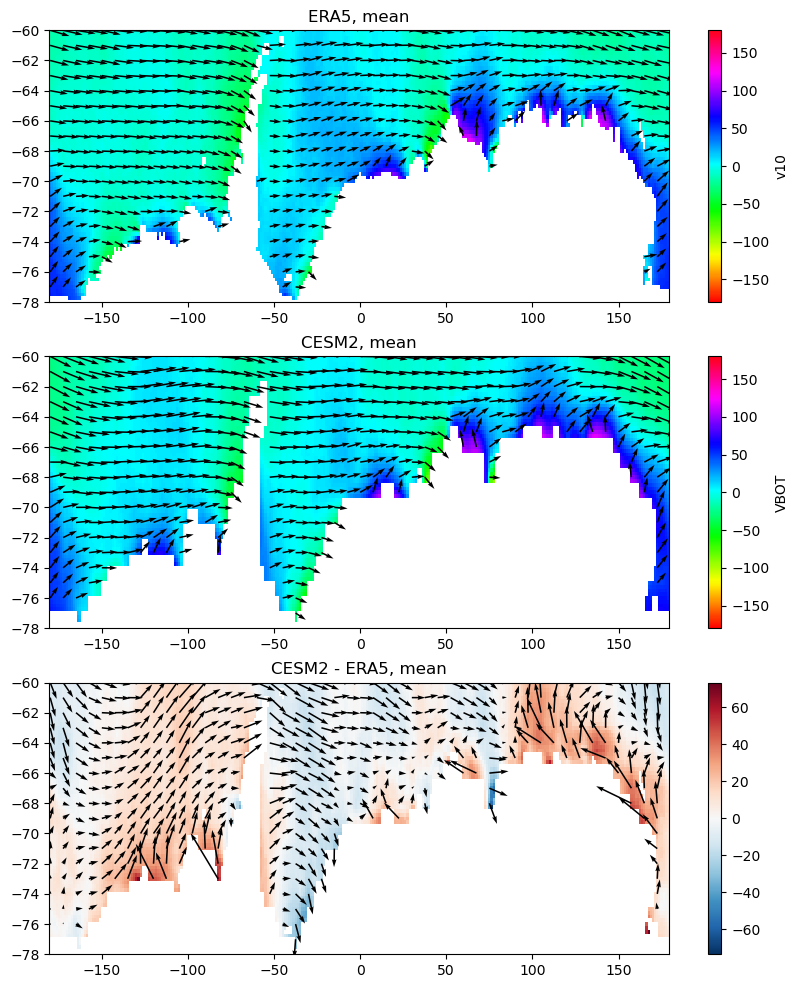

In [53]:
fig, ax = plt.subplots(3,1,figsize=(10,12))
subset  = {'lon':slice(0,None,6), 'lat':slice(0,None,4)}

a = np.rad2deg(ERA5_monthly_angle.mean(dim='month'))
b = np.rad2deg(CESM2_monthly_angle.mean(dim='month')).interp(lon=a.lon, lat=a.lat)
b1 = CESM2_mean_u.wind_speed.mean(dim='month').interp(lon=a.lon, lat=a.lat)
b2 = CESM2_mean_v.wind_speed.mean(dim='month').interp(lon=a.lon, lat=a.lat)

a.plot(ax=ax[0], cmap='hsv', vmin=-180, vmax=180)
b.plot(ax=ax[1], cmap='hsv', vmin=-180, vmax=180)
(b-a).plot(ax=ax[2])

# quiver:
ql = ax[0].quiver(a.isel(**subset).lon,a.isel(**subset).lat,
                  ERA5_mean_u.wind_speed.mean(dim='month').isel(**subset).values, ERA5_mean_v.wind_speed.mean(dim='month').isel(**subset).values,
                  width=2.5e-3, scale=320, color='k')
ql = ax[1].quiver(b.isel(**subset).lon,b.isel(**subset).lat, 
                  b1.isel(**subset).values, b2.isel(**subset).values, width=2.5e-3, scale=320, color='k')
ql = ax[2].quiver(b.isel(**subset).lon, b.isel(**subset).lat, (b1-ERA5_mean_u.wind_speed.mean(dim='month')).isel(**subset).values, 
                  (b2-ERA5_mean_v.wind_speed.mean(dim='month')).isel(**subset).values,
                  width=2.5e-3, scale=100, color='k')

ax[0].set_title(f'ERA5, mean')
ax[1].set_title(f'CESM2, mean')
ax[2].set_title(f'CESM2 - ERA5, mean')
    
for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');
    # axis.set_xlim(-75, 100)
    axis.set_ylim(-78, -60)